In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# 1. Load data
start_df = pd.read_csv('Data.csv')
start_df['Dates'] = pd.to_datetime(start_df['Dates'])
start_df = start_df.sort_values('Dates').set_index('Dates')

# 2. Clean the dataset and reject the negative price. It's the pragmatic thing to do at this stage.
start_df = start_df[start_df > 0]

# 3. I do not know how to handle things I cannot convert into USD. So I drop them.
start_df = start_df.drop(['Brazil_Equity', 'Australia_Equity', 'UK_10y','CADBRL','GBPMXN','SGDBRL','CHFJPY'], axis=1)

# Definizione delle valute per ciascun asset (in base all'immagine)
asset_currency = {
    'Germany_Equity': 'EUR',
    'Spain_Equity': 'EUR',
    'Germany_2y': 'EUR',
    'Germany_10y': 'EUR',
    'Japan_Equity': 'JPY',
    'Japan_10y': 'JPY',
    'Nasdaq': 'USD',
    'US_2y': 'USD',
    'US_10y': 'USD',
    'Gold': 'USD',
    'Oil': 'USD',
    'Wheat': 'USD',
    'Corn': 'USD',
    'Rice': 'USD',
    'Copper': 'USD'
}

# Prepariamo un nuovo DataFrame con i prezzi convertiti in USD
df_usd = pd.DataFrame(index=start_df.index)

for col in start_df.columns:
    if col in ['EURUSD', 'USDJPY']:  # saltiamo i tassi di cambio
        continue
    currency = asset_currency.get(col)
    if currency == 'USD':
        df_usd[col] = start_df[col]  # già in USD
    elif currency == 'EUR':
        df_usd[col] = start_df[col] * start_df['EURUSD']
    elif currency == 'JPY':
        df_usd[col] = start_df[col] / start_df['USDJPY']  # conversione JPY → USD
    else:
        pass  # ignora colonne senza valuta definita


In [88]:
df_usd

,Germany_Equity,Nasdaq,Japan_Equity,Spain_Equity,US_2y,US_10y,Germany_2y,Germany_10y,Japan_10y,Gold,Oil,Wheat,Corn,Rice,Copper
Dates,,,,,,,,,,,,,,,
2010-05-06,7553.85225,1886.00,115.772358,11806.67425,109.195312,119.921875,139.655544,161.721833,1.516098,1197.3,77.11,497.25,364.00,11.650,310.35
2010-05-07,7298.41100,1848.50,113.877061,11387.66400,109.101562,119.687500,139.839443,161.950235,1.527569,1210.4,75.11,500.25,364.75,11.535,313.10
2010-05-10,7686.64050,1939.50,113.017371,13127.68800,109.039062,118.937500,140.301525,160.752690,1.497534,1200.8,76.80,482.50,363.00,11.690,321.50
2010-05-11,7699.95775,1935.25,111.743849,12750.00865,109.039062,119.015625,139.631423,160.090309,1.501451,1220.3,76.37,483.75,369.75,11.690,319.40
2010-05-12,7841.65760,1972.75,111.313869,12755.34960,109.015625,118.796875,138.722416,159.047952,1.501181,1243.1,75.65,482.75,371.75,11.785,317.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-28,25576.61540,19528.00,252.283265,15292.67987,103.960938,111.906250,122.685367,149.792197,0.987987,3332.5,62.05,515.50,475.50,12.510,484.05
2025-04-29,25771.92030,19642.00,252.798310,15258.81042,104.003906,112.156250,122.599355,149.824017,0.990004,3333.6,60.42,505.75,460.50,12.475,482.30
2025-04-30,25670.23800,19658.50,252.523129,15043.52032,104.074219,112.218750,122.156492,149.649368,0.985772,3319.1,58.21,513.00,467.25,12.945,456.00


In [89]:
df_log_returns = np.log(df_usd / df_usd.shift(1)).dropna()

In [90]:
corr_matrix = df_log_returns.rolling(32).corr().dropna()

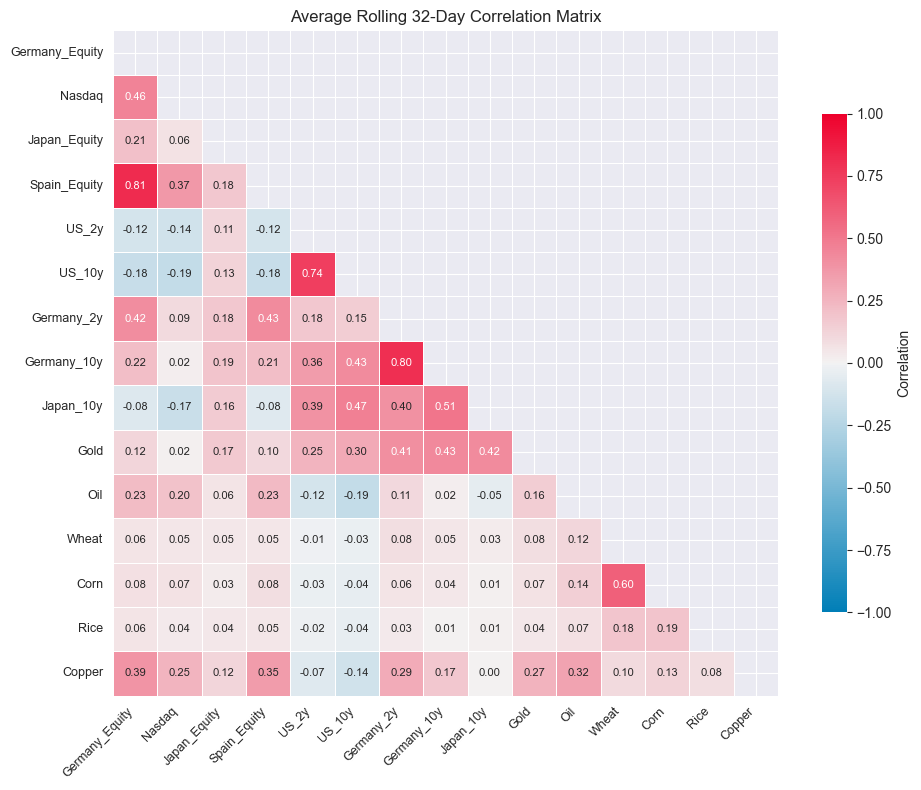

In [91]:
# Rolling correlation (multi-index)
rolling_corr = df_log_returns.rolling(32).corr()

# Ricomponi le matrici in un cubo (time, asset1, asset2)
assets = df_log_returns.columns
dates = df_log_returns.index[31:]  # le prime 31 sono NaN
n_assets = len(assets)
n_dates = len(dates)

# Pivot per ottenere (n_dates, n_assets, n_assets)
corr_cube = np.empty((n_dates, n_assets, n_assets))

for i, date in enumerate(dates):
    corr_matrix = rolling_corr.loc[date]
    corr_cube[i] = corr_matrix.values

# Media delle matrici nel tempo
avg_corr_matrix = np.mean(corr_cube, axis=0)

mask = np.triu(np.ones_like(avg_corr_matrix, dtype=bool))
palette = sns.diverging_palette(240, 10, n=9, s=100, l=50, as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(
    avg_corr_matrix,
    mask=mask,
    cmap=palette,        # diverging palette
    vmin=-1, vmax=1,        # ensure full correlation range
    center=0,
    annot=True,             # show numbers
    fmt=".2f",              # 2 decimal places
    annot_kws={"size": 8},  # control number size
    square=True,            # make cells square
    linewidths=0.5,         # white lines between cells
    xticklabels=assets,     # <— here
    yticklabels=assets,
    cbar_kws={"shrink": 0.75, "label": "Correlation"})
plt.title("Average Rolling 32-Day Correlation Matrix")
# Tweak the tick labels
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()
plt.close()

In [92]:
# rolling correlation su 32 giorni
rolling_corrs = {}
window = 32

for a1, a2 in combinations(df_log_returns.columns, 2):
    pair_name = f"{a1}-{a2}"
    corr_series = df_log_returns[a1].rolling(window).corr(df_log_returns[a2])
    rolling_corrs[pair_name] = corr_series

# metti tutto in un DataFrame
rolling_corr_df = pd.DataFrame(rolling_corrs)

# calcola media e std delle correlazioni rolling negli ultimi N giorni (es. ultimi 32)
summary = pd.DataFrame({
    'mean_corr': rolling_corr_df.tail(32).mean(),
    'std_corr': rolling_corr_df.tail(32).std()
})

# ordina per correlazione alta
summary = summary.sort_values(by=['mean_corr'], ascending=False)

print(summary.head(10))  # Le 10 coppie migliori

                             mean_corr  std_corr
US_2y-US_10y                  0.888424  0.015910
Germany_Equity-Spain_Equity   0.883615  0.040207
Germany_2y-Germany_10y        0.757978  0.164948
Germany_10y-Japan_10y         0.641551  0.126104
Wheat-Corn                    0.634032  0.042717
Germany_Equity-Copper         0.614068  0.076734
Germany_Equity-Japan_Equity   0.588864  0.192293
Spain_Equity-Copper           0.576500  0.156821
Nasdaq-Oil                    0.548707  0.193547
Japan_Equity-Spain_Equity     0.533028  0.289392


In [93]:
trades = [summary.index[0].split("-")
        ,summary.index[1].split("-")
        ,summary.index[2].split("-")
        ,summary.index[3].split("-")
        ,summary.index[4].split("-")]

In [94]:
def compute_spread(df_prices, asset1, asset2):
    log_price_1 = np.log(df_prices[asset1])
    log_price_2 = np.log(df_prices[asset2])
    spread = log_price_1 - log_price_2
    return spread

spreads = {}
for a1, a2 in trades:
    spread = compute_spread(start_df, a1, a2)
    pair_name = f"{a1}-{a2}"
    spreads[pair_name] = spread

df_spreads = pd.DataFrame(spreads)

def compute_zscore(spread, window=32):
    mean = spread.rolling(window).mean()
    std = spread.rolling(window).std()
    zscore = (spread - mean) / std
    return zscore
z_scores = {}

for pair_name, spread_series in spreads.items():
    z = compute_zscore(spread_series, window=32)
    z_scores[pair_name] = z

df_zscores = pd.DataFrame(z_scores)
df_zscores = df_zscores.dropna()


In [95]:
# def run_strategy_on_pair(spread_series, z_series,
#                          z_entry=2.0, z_exit=0.5, z_stop=3.0, max_holding=32):
#     trades = []
#     position = None  # None, 'long', 'short'
#     entry_day = None
#     entry_spread = None
#     entry_z = None
#
#     for day in range(len(spread_series)):
#         z = z_series.iloc[day]
#         date = z_series.index[day]
#         spread = spread_series.iloc[day]
#
#         if pd.isna(z):
#             continue
#
#         # ENTRY
#         if position is None:
#             if z > z_entry:
#                 position = 'short'  # short asset1, long asset2
#                 entry_day = date
#                 entry_spread = spread
#                 entry_z = z
#             elif z < -z_entry:
#                 position = 'long'  # long asset1, short asset2
#                 entry_day = date
#                 entry_spread = spread
#                 entry_z = z
#
#         # EXIT
#         elif position is not None:
#             days_open = (date - entry_day).days
#
#             # take profit
#             if abs(z) < z_exit:
#                 reason = 'take_profit'
#             # stop loss
#             elif abs(z) > z_stop:
#                 reason = 'stop_loss'
#             # time limit
#             elif (date - entry_day).days >= (max_holding - 1):
#                 reason = 'time_limit'
#             else:
#                 continue  # keep position
#
#             # compute PnL (differenza spread, direzione coerente)
#             pnl = spread - entry_spread if position == 'long' else entry_spread - spread
#
#             trades.append({
#                 'entry_date': entry_day,
#                 'exit_date': date,
#                 'position': position,
#                 'entry_z': entry_z,
#                 'exit_z': z,
#                 'entry_spread': entry_spread,
#                 'exit_spread': spread,
#                 'pnl': pnl,
#                 'duration': days_open,
#                 'reason': reason
#             })
#
#             # reset position
#             position = None
#             entry_day = None
#             entry_spread = None
#             entry_z = None
#
#     return pd.DataFrame(trades)


In [96]:
def run_strategy_with_risk_control(spread_series, z_series,
                                    z_entry=2.0, z_exit=0.5, z_stop=3.0,
                                    max_holding=32, aum=100_000_000):
    """
    Strategia mean-reverting con sizing dinamico per controllare il rischio.
    Ogni trade è dimensionato in modo che, se scatta lo stop-loss, la perdita non superi l'1% dell'AUM.
    """

    # Calcola la deviazione standard rolling dello spread (necessaria per il sizing)
    rolling_std = spread_series.rolling(window=32).std()

    # Inizializza la lista dei trade e lo stato interno
    trades = []
    position = None
    entry_day = None
    entry_spread = None
    entry_z = None
    entry_std = None
    notional = None
    risk_per_trade = 0.01 * aum  # 1% dell'AUM

    # Loop giorno per giorno sulla serie temporale
    for day in range(len(spread_series)):
        z = z_series.iloc[day]
        date = z_series.index[day]
        spread = spread_series.iloc[day]
        sigma = rolling_std.iloc[day]

        # Skippa i giorni con dati mancanti
        if pd.isna(z) or pd.isna(sigma):
            continue

        # Se non abbiamo una posizione aperta: valuta l'ingresso
        if position is None:
            if z > z_entry:
                # Entra short spread (short asset1, long asset2)
                position = 'short'
                entry_day = date
                entry_spread = spread
                entry_z = z
                entry_std = sigma

                # Calcola la massima perdita prevista sullo spread
                max_spread_loss = abs(z_stop - z_entry) * sigma

                # Dimensiona il notional per limitare la perdita al 1% dell'AUM
                notional = risk_per_trade / max_spread_loss

            elif z < -z_entry:
                # Entra long spread (long asset1, short asset2)
                position = 'long'
                entry_day = date
                entry_spread = spread
                entry_z = z
                entry_std = sigma

                max_spread_loss = abs(z_stop - z_entry) * sigma
                notional = risk_per_trade / max_spread_loss

        # Se hai un trade aperto: valuta se chiudere
        elif position is not None:
            days_open = (date - entry_day).days + 1  # include il giorno di entrata

            # Take profit: lo spread è tornato vicino alla media
            if abs(z) < z_exit:
                reason = 'take_profit'

            # Stop loss: lo z-score è andato oltre il limite
            elif abs(z) > z_stop:
                reason = 'stop_loss'

            # Time limit: raggiunto il massimo di giorni
            elif days_open >= max_holding:
                reason = 'time_limit'

            else:
                continue  # niente da fare, resta aperto

            # Calcola il profit/loss in spread e in dollari
            pnl = (spread - entry_spread if position == 'long'
                   else entry_spread - spread)
            pnl_usd = pnl * notional

            # Salva il trade nel log
            trades.append({
                'entry_date': entry_day,
                'exit_date': date,
                'position': position,
                'entry_z': entry_z,
                'exit_z': z,
                'entry_spread': entry_spread,
                'exit_spread': spread,
                'pnl_spread': pnl,
                'pnl_usd': pnl_usd,
                'notional': notional,
                'entry_sigma': entry_std,
                'duration': days_open,
                'reason': reason
            })

            # Reset dello stato interno
            position = None
            entry_day = None
            entry_spread = None
            entry_z = None
            entry_std = None
            notional = None

    # Ritorna tutti i trade come DataFrame
    return pd.DataFrame(trades)


In [97]:
results = []

# Assumiamo che le colonne siano le stesse in df_spreads e df_zscores
common_cols = df_spreads.columns.intersection(df_zscores.columns)

for col in common_cols:
    # Trova le date comuni per questa coppia
    common_dates = df_spreads.index.intersection(df_zscores.index)

    # Estrai le serie allineate
    spread_series = df_spreads.loc[common_dates, col]
    zscore_series = df_zscores.loc[common_dates, col]

    # Esegui la strategia
    trades = run_strategy_with_risk_control(spread_series, zscore_series)
    trades['pair'] = col  # aggiungi nome coppia ai risultati

    # Salva i risultati
    results.append(trades)

# Unisci tutti i trade in un unico DataFrame
all_trades = pd.concat(results, ignore_index=True)

# Mostra i primi risultati
print(all_trades.head())


  entry_date  exit_date position   entry_z    exit_z  entry_spread  \
0 2010-08-06 2010-09-03     long -2.281693 -0.117646     -0.127654   
1 2010-10-06 2010-10-15     long -2.238689 -0.256168     -0.146008   
2 2010-11-15 2010-12-16    short  2.602831  1.862434     -0.129229   
3 2011-02-04 2011-02-22    short  2.523329 -0.358161     -0.082434   
4 2011-03-14 2011-03-23     long -2.007826  0.252081     -0.102407   

   exit_spread  pnl_spread       pnl_usd      notional  entry_sigma  duration  \
0    -0.130892   -0.003238 -5.571488e+05  1.720542e+08     0.005812        29   
1    -0.138584    0.007425  1.626187e+06  2.190237e+08     0.004566        10   
2    -0.094973   -0.034256 -7.089044e+06  2.069416e+08     0.004832        32   
3    -0.093633    0.011199  2.472781e+06  2.207974e+08     0.004529        19   
4    -0.090522    0.011885  1.918340e+06  1.614056e+08     0.006196        10   

        reason          pair  
0  take_profit  US_2y-US_10y  
1  take_profit  US_2y-US_10y  

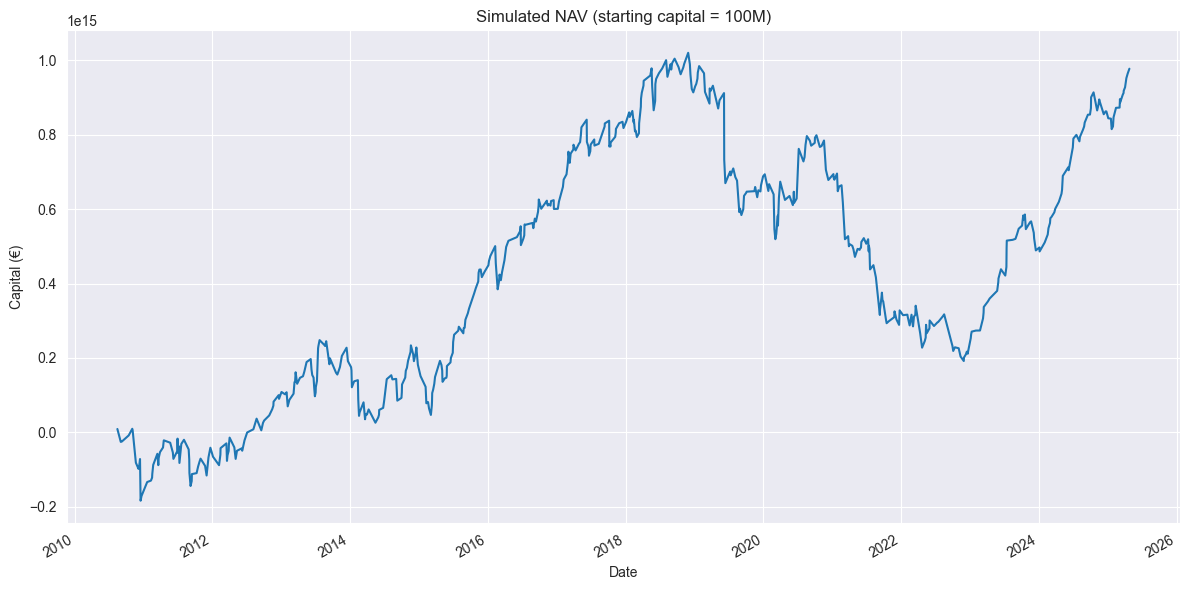

📈 Rendimento totale: 967,496,077,629,721.62 € (10359.53%)
📉 Max drawdown: -827,673,062,473,622.38 €
📊 Sharpe ratio (daily, annualized): -0.22
pair
Wheat-Corn                     7.361459e+14
Germany_10y-Japan_10y          3.821272e+14
Germany_Equity-Spain_Equity    1.339453e+14
US_2y-US_10y                  -5.767604e+13
Germany_2y-Germany_10y        -2.177072e+14
Name: pnl_euro, dtype: float64


In [99]:
notional = 1e7  # 10 milioni per trade
all_trades['pnl_euro'] = all_trades['pnl_usd'] * notional


# Ordina i trade per data di uscita
all_trades = all_trades.sort_values('exit_date')

# Crea DataFrame con date e pnl
pnl_series = all_trades.groupby('exit_date')['pnl_euro'].sum().cumsum()

# Capitale iniziale
starting_capital = 100_000_000
nav_series = starting_capital + pnl_series


plt.figure(figsize=(12, 6))
nav_series.plot()
plt.title("Simulated NAV (starting capital = 100M)")
plt.ylabel("Capital (€)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

# Ricostruisci un DateTimeIndex completo
all_dates = pd.date_range(start=nav_series.index.min(), end=nav_series.index.max())

# Reindicizza e fill-forward
nav_full = nav_series.reindex(all_dates).ffill().fillna(starting_capital)

total_return = nav_full.iloc[-1] - nav_full.iloc[0]
total_return_pct = (nav_full.iloc[-1] / nav_full.iloc[0] - 1) * 100

daily_returns = nav_full.pct_change().dropna()
sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

rolling_max = nav_full.cummax()
drawdown = nav_full - rolling_max
max_drawdown = drawdown.min()

print(f"📈 Rendimento totale: {total_return:,.2f} € ({total_return_pct:.2f}%)")
print(f"📉 Max drawdown: {max_drawdown:,.2f} €")
print(f"📊 Sharpe ratio (daily, annualized): {sharpe:.2f}")

by_pair = all_trades.groupby('pair')['pnl_euro'].sum().sort_values(ascending=False)
print(by_pair)
